In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from textblob import TextBlob
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\iyeng\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


device(type='cuda')

## Cleaning and splitting
Skip to bottom to read in final CSVs

In [2]:
full_data = pd.read_csv('full_data.csv')
full_data.head()

,submission_title,comment,comment_id,url,subreddit_id,label1,label2
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,ip5g6vu,/r/india/comments/xif8wm/shashi_tharoor_set_to...,2qh1q,-1,-1
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper -...,hcontm8,/r/india/comments/pmn9o3/yogi_government_puts_...,2qh1q,-1,-1
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,fbhlv40,/r/india/comments/ebdeup/an_attempt_to_address...,2qh1q,-1,-2
3,You guys noticing what's happening in Sri Lanka?,>The blockade was done by your own people.\n\n...,i2yrud3,/r/india/comments/tt1ryh/you_guys_noticing_wha...,2qh1q,0,0
4,Just got abused on the train by a hyper-nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,hooi92k,/r/india/comments/rh2kcs/just_got_abused_on_th...,2qh1q,-2,-2


In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   submission_title  3000 non-null   object
 1   comment           3000 non-null   object
 2   comment_id        3000 non-null   object
 3   url               3000 non-null   object
 4   subreddit_id      3000 non-null   object
 5   label1            3000 non-null   int64 
 6   label2            3000 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 164.2+ KB


In [298]:
def clean_quotations(text):
    temp = re.sub(r'>.*?\n', '', text)
    return temp
def clean_url(text):
    temp = re.sub(r'(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+\.~#?&\/=]*)', '', text)
    return temp
def clean_text(text):
    temp = clean_quotations(text)
    temp = clean_url(temp)
    temp = re.sub('\’', "\'", temp)  # apostrophe formatting is occasionally incorrect
    temp = re.sub(r'[^a-zA-Z0-9\s\.,?!\'\"]', ' ', temp)
    temp = re.sub(r'\s+', ' ', temp)  # replace multiple spaces with single space
    return temp.strip()

In [12]:
full_clean_df = pd.DataFrame()
full_clean_df['clean_title'] = full_data.apply(lambda x: clean_text(x['submission_title']), axis=1)
full_clean_df['clean_comment'] = full_data.apply(lambda x: clean_text(x['comment']), axis=1)
full_clean_df[['comment_id', 'url']] = full_data[['comment_id', 'url']].copy()
full_clean_df['target'] = full_data.apply(lambda x: np.mean([x['label1'], x['label2']])/2, axis=1)
# making sure to remove comments that are empty after cleaning
full_clean_df['clean_comment'].replace('', np.nan, inplace=True)
full_clean_df.dropna(inplace=True)
full_clean_df.head()

,clean_title,clean_comment,comment_id,url,target
0,Shashi Tharoor Set To Run For Congress Preside...,Extremely valid points but I believe he has th...,ip5g6vu,/r/india/comments/xif8wm/shashi_tharoor_set_to...,-0.50
1,Yogi government puts Kolkata's image as part o...,Even if the ad was designed by the newspaper t...,hcontm8,/r/india/comments/pmn9o3/yogi_government_puts_...,-0.50
2,"An attempt to address the list of ""simplified""...",Diverse population including Muslims. Welcomin...,fbhlv40,/r/india/comments/ebdeup/an_attempt_to_address...,-0.75
3,You guys noticing what's happening in Sri Lanka?,What a joke. They didn't create any propaganda...,i2yrud3,/r/india/comments/tt1ryh/you_guys_noticing_wha...,0.00
4,Just got abused on the train by a hyper nation...,Ohoo bahut bura laga ye sunke ki aap Undergarm...,hooi92k,/r/india/comments/rh2kcs/just_got_abused_on_th...,-1.00


In [13]:
full_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clean_title    2999 non-null   object 
 1   clean_comment  2999 non-null   object 
 2   comment_id     2999 non-null   object 
 3   url            2999 non-null   object 
 4   target         2999 non-null   float64
dtypes: float64(1), object(4)
memory usage: 140.6+ KB


In [17]:
temp = full_clean_df.sample(frac=1, random_state=123).reset_index(drop=True)  # shuflling before split
eval_df = temp[:1000].copy()
train_df = temp[1000:].copy().reset_index(drop=True)

In [20]:
full_clean_df.to_csv('cleaned_full_data.csv', index=False)
train_df.to_csv('train_full.csv', index=False)
eval_df.to_csv('eval_full.csv', index=False)

In [2]:
# start here
train_df = pd.read_csv('train_full.csv')
eval_df = pd.read_csv('eval_full.csv')

## Rule-Based

In [3]:
right = """right wing, RW, authority, hierarchy, order, duty, tradition, reaction, nationalism, conservative, right-libertarian, \
neoconservative, imperialist, monarchist, fascist, reactionaries, traditionalist, traditional, death penalty, \
religion, Bhajpa, BJP, Shiv Sena, RSS, MNS, Sanatan, dharm, Hindutva, Islamophobia, Narendra, Modi, Amit, Shah, \
mandir, ram, valmiki, ramayan, Bharatiya, Janata, Democratic Alliance, NDA, AIADMK, Janta Dal, bhakt, CAA, NRC, hindu majority, \
hindu unity, hindu pride, nationalist, sangh, sanghi, yogi, brahmin, brahman, smriti irani, hindu rashtra, jai shri ram, \
pm cares, pmcares, adani, hindu""".lower()
left = """left wing, LW, leftists, freedom, equality, fraternity, rights, progress, reform, internationalism, anarchist, communist, socialist, \
democratic socialist, social democrat, left-libertarian, progressive, social, liberal, western, Congress, UPA, RG, mamata, \
Aam, aadmi, AAP, CPI, Welfare, Protectionism, Commies, Rahul, gandhi, indira, yatra, arvind, kejriwal, inclusivity, \
libby, libbies, sjw, libtard, hinduphobia, LGBTQ, masjid, pappu, christian, muslim, secular, minority, minorities, Shashi, Tharoor, \
gay, lesbian, transgender, trans, reservation, abrahamic""".lower()

right_terms = set(right.split(', '))
left_terms = set(left.split(', '))
len(right_terms), len(left_terms)

(62, 59)

In [4]:
vader = SentimentIntensityAnalyzer()

In [5]:
def unsupervised_prediction(clean_text):
    # rule-based scoring
    sentiment = vader.polarity_scores(clean_text)['compound']
    lw = rw = 0
    clean_text = clean_text.lower()
    for t in left_terms:
        if re.search(r'\b'+t, clean_text):
            lw += 1
    for t in right_terms:
        if re.search(r'\b'+t, clean_text):
            rw += 1
    
    score = (rw-lw)*sentiment
    # normalize by length of text
    score /= len(clean_text.split())/20
    
    return score

def conv_to_label(val, threshold=0.1):
    # converts rule-based score to label
    if abs(val)<threshold:
        return 0.
    else:
        return np.sign(val)

In [6]:
pred_df = eval_df.copy()
pred_df['true_label'] = pred_df.apply(lambda x: np.sign(x['target']), axis=1)
pred_df['vader_score'] = pred_df.apply(lambda x: unsupervised_prediction(x['clean_comment']), axis=1)
pred_df['vader_label'] = pred_df.apply(lambda x: conv_to_label(x['vader_score'], threshold=0.1), axis=1)
pred_df.head()

,clean_title,clean_comment,comment_id,url,target,true_label,vader_score,vader_label
0,ResignModi trending in India on 1 with 200k tw...,"People tend to look down on ""social media acti...",gwe056n,/r/india/comments/n11sqc/resignmodi_trending_i...,-0.5,-1.0,-0.000000,0.0
1,"Put 'The Kashmir Files' on YouTube, everyone w...","I remember it was made to release twice, and t...",i1y3pv3,/r/india/comments/tmcun4/put_the_kashmir_files...,0.0,0.0,0.000000,0.0
2,Kejriwal says 'The Kashmir Files' is a jhoothi...,Bhai delhi m hindu bht h but ye aur caste k lo...,i21haf8,/r/IndiaSpeaks/comments/tmhqqg/kejriwal_says_t...,0.5,1.0,0.320255,1.0
3,Government of India has Blacklisted Karl Rock ...,mahatma gandhi's shadows are fading. retards w...,h4lazw7,/r/india/comments/ogrc0d/government_of_india_h...,-1.0,-1.0,-0.131556,-1.0
4,Kejriwal says 'The Kashmir Files' is a jhoothi...,Isn't this kejru the same guy who kept tweetin...,i1yrkwx,/r/IndiaSpeaks/comments/tmhqqg/kejriwal_says_t...,0.5,1.0,0.000000,0.0


In [7]:
np.mean(pred_df['true_label']==pred_df['vader_label'])  # 3-class accuracy

0.502

In [8]:
confusion_matrix(pred_df['true_label'], pred_df['vader_label'])

array([[ 98, 166,  71],
       [ 28, 339,  47],
       [ 58, 128,  65]], dtype=int64)

In [9]:
print(classification_report(pred_df['true_label'], pred_df['vader_label'], target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.53      0.29      0.38       335
     Neutral       0.54      0.82      0.65       414
       Right       0.36      0.26      0.30       251

    accuracy                           0.50      1000
   macro avg       0.47      0.46      0.44      1000
weighted avg       0.49      0.50      0.47      1000



<AxesSubplot:ylabel='Density'>

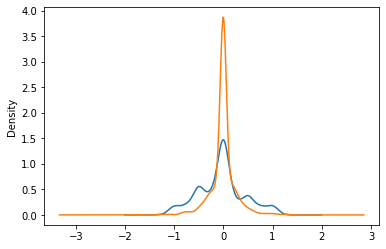

In [10]:
pred_df['target'].plot.kde()
pred_df['vader_score'].plot.kde()

In [18]:
y_rule_based = list(pred_df['vader_label']+1)

## Feature Extracted XGBoost

In [12]:
def feature_extraction(clean_text):
    clean_text = clean_text.lower()
    features = []
    for t in left_terms:
        features.append(len(re.findall(r'\b'+t, clean_text)))
    for t in right_terms:
        features.append(len(re.findall(r'\b'+t, clean_text)))
    
    return features

def add_sentiment_features(clean_text, extracted_feat):
    # appends sentiment scores onto extracted features
    temp = extracted_feat.copy()
    temp.append(vader.polarity_scores(clean_text)['compound'])
    tb = TextBlob(clean_text)
    temp.append(tb.sentiment.polarity)
    temp.append(tb.sentiment.subjectivity)
    return temp

In [165]:
# getting train embeddings
temp_df = train_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

# getting eval embeddings
temp_df = eval_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_test, y_test = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

print(len(X_train), len(y_train), len(X_test), len(y_test))

1999 1999 1000 1000


In [175]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.574


In [15]:
confusion_matrix(y_test, y_pred)

array([[138, 161,  36],
       [ 43, 364,   7],
       [ 62, 117,  72]], dtype=int64)

In [16]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.57      0.41      0.48       335
     Neutral       0.57      0.88      0.69       414
       Right       0.63      0.29      0.39       251

    accuracy                           0.57      1000
   macro avg       0.59      0.53      0.52      1000
weighted avg       0.58      0.57      0.54      1000



In [17]:
y_feat_ext = y_pred

## Feature Extraction with PCA

In [19]:
pca = PCA(n_components=8)

# getting train embeddings
temp_df = train_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['extracted_features'] = pca.fit_transform(list(temp_df['extracted_features'])).tolist()  # fit transform PCA
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

# getting eval embeddings
temp_df = eval_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['extracted_features'] = pca.transform(list(temp_df['extracted_features'])).tolist()  # transform PCA without re-fitting
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_test, y_test = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

print(len(X_train), len(y_train), len(X_test), len(y_test))

1999 1999 1000 1000


In [20]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.005)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.562


In [21]:
confusion_matrix(y_test, y_pred)

array([[167, 121,  47],
       [ 55, 327,  32],
       [ 93,  90,  68]], dtype=int64)

In [22]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.53      0.50      0.51       335
     Neutral       0.61      0.79      0.69       414
       Right       0.46      0.27      0.34       251

    accuracy                           0.56      1000
   macro avg       0.53      0.52      0.51      1000
weighted avg       0.55      0.56      0.54      1000



In [23]:
y_feat_pca = y_pred

## tf-idf word embeddings with XGBoost

In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word')

X_train = vectorizer.fit_transform(list(train_df['clean_comment']))
X_test = vectorizer.transform(list(eval_df['clean_comment']))
y_train, y_test = [np.sign(x)+1 for x in list(train_df['target'])], [np.sign(x)+1 for x in list(eval_df['target'])]

print(X_train.shape, X_test.shape)

(1999, 92418) (1000, 92418)


In [25]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.001)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.528


In [26]:
confusion_matrix(y_test, y_pred)

array([[112, 209,  14],
       [ 26, 376,  12],
       [ 53, 158,  40]], dtype=int64)

In [27]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.59      0.33      0.43       335
     Neutral       0.51      0.91      0.65       414
       Right       0.61      0.16      0.25       251

    accuracy                           0.53      1000
   macro avg       0.57      0.47      0.44      1000
weighted avg       0.56      0.53      0.48      1000



In [28]:
y_w_tfidf = y_pred

## tf-idf word embeddings with PCA and sentiment
Since PCA doesn't work for sparse data, we use TruncatedSVD for the same effect

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word')
tsvd = TruncatedSVD(n_components=200, random_state=123)

temp_df = train_df.copy()
X_train = vectorizer.fit_transform(list(temp_df['clean_comment']))
temp_df['extracted_features'] = tsvd.fit_transform(X_train).tolist()
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

temp_df = eval_df.copy()
X_test = vectorizer.transform(list(temp_df['clean_comment']))
temp_df['extracted_features'] = tsvd.transform(X_test).tolist()
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_test, y_test = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

In [30]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.493


In [31]:
confusion_matrix(y_test, y_pred)

array([[139, 147,  49],
       [ 81, 294,  39],
       [ 89, 102,  60]], dtype=int64)

In [32]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.45      0.41      0.43       335
     Neutral       0.54      0.71      0.61       414
       Right       0.41      0.24      0.30       251

    accuracy                           0.49      1000
   macro avg       0.47      0.45      0.45      1000
weighted avg       0.48      0.49      0.47      1000



In [33]:
y_tfidf_pca = y_pred

## tf-idf sub-word embeddings

In [34]:
vectorizer = TfidfVectorizer(ngram_range=(2, 10), analyzer='char_wb')

X_train = vectorizer.fit_transform(list(train_df['clean_comment']))
X_test = vectorizer.transform(list(eval_df['clean_comment']))
y_train, y_test = [np.sign(x)+1 for x in list(train_df['target'])], [np.sign(x)+1 for x in list(eval_df['target'])]

print(X_train.shape, X_test.shape)

(1999, 222782) (1000, 222782)


In [35]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.563


In [36]:
confusion_matrix(y_test, y_pred)

array([[135, 158,  42],
       [ 44, 350,  20],
       [ 55, 118,  78]], dtype=int64)

In [37]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.58      0.40      0.47       335
     Neutral       0.56      0.85      0.67       414
       Right       0.56      0.31      0.40       251

    accuracy                           0.56      1000
   macro avg       0.56      0.52      0.52      1000
weighted avg       0.56      0.56      0.54      1000



In [38]:
y_sw_tfidf = y_pred

## Data Augmentation with tf-idf/XGBoost

In [39]:
list_right_terms = list(right_terms)
list_left_terms = list(left_terms)
full_terms = left_terms.union(right_terms)

In [40]:
def random_swap(term):
    if term in left_terms:
        # LW term being swapped
        return np.random.choice(list_right_terms)
    elif term in right_terms:
        # RW term being swapped
        return np.random.choice(list_left_terms)
    print(f"Error with: {term}")

def swap_terms(text):
    term_match = re.compile('|'.join([r'\b'+t for t in full_terms]))
    
    temp = term_match.sub(lambda m: random_swap(m.group()), text.lower())
    return temp

In [50]:
aug_records = []
for i, row in train_df.iterrows():
    aug_records.append({'clean_comment':row['clean_comment'].lower(), 'target':row['target']})
    # adding in record with swapped terms and opposite score
    aug_records.append({'clean_comment':swap_terms(row['clean_comment']), 'target':-row['target']})
aug_df = pd.DataFrame.from_records(aug_records)
aug_df

,clean_comment,target
0,there are two types of parties those that prom...,0.00
1,there are two types of parties those that prom...,-0.00
2,"if fundamentals are sound then, faith can help...",0.75
3,"if fundamentals are sound then, faith can help...",-0.75
4,"contrary to popular belief, until modi, india ...",-0.50
...,...,...
3993,it is good a initiative but the plastic in roa...,-0.00
3994,"yup, been reading about it since couple of wee...",0.00
3995,"yup, been reading about it since couple of wee...",-0.00
3996,first i thought christmas ke chakkar me. then ...,0.00


In [306]:
vectorizer = TfidfVectorizer(ngram_range=(2, 10), analyzer='char_wb')

X_train = vectorizer.fit_transform(list(aug_df['clean_comment']))
X_test = vectorizer.transform(list(eval_df['clean_comment']))
y_train, y_test = [np.sign(x)+1 for x in list(aug_df['target'])], [np.sign(x)+1 for x in list(eval_df['target'])]

print(X_train.shape, X_test.shape)

(3998, 232104) (1000, 232104)


In [307]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.541


In [308]:
confusion_matrix(y_test, y_pred)

array([[117, 179,  39],
       [ 45, 343,  26],
       [ 59, 111,  81]], dtype=int64)

In [309]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.53      0.35      0.42       335
     Neutral       0.54      0.83      0.66       414
       Right       0.55      0.32      0.41       251

    accuracy                           0.54      1000
   macro avg       0.54      0.50      0.49      1000
weighted avg       0.54      0.54      0.51      1000



In [55]:
y_aug = y_pred

## Frozen Indian-sBERT embeddings with XGBoost
### Note: do NOT re-run this section without a powerful GPU. The pretrained model is massive.

In [56]:
model_name = "meedan/indian-sbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# freezing everything
modules = [model.embeddings, *model.encoder.layer]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [57]:
# getting train embeddings from model
with torch.no_grad():
    model.eval()
    X_train = []
    batch_size = 16
    for i in range(0, len(train_df), batch_size):
        temp = tokenizer(list(train_df['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
        X_train.extend(model(temp['input_ids'].to(device), temp['attention_mask'].to(device)).pooler_output.cpu().detach().numpy().tolist())
      
print(len(X_train), len(X_train[0]))

1999 768


In [58]:
# getting eval embeddings from model
with torch.no_grad():
    model.eval()
    X_test = []
    batch_size = 16
    for i in range(0, len(eval_df), batch_size):
        temp = tokenizer(list(eval_df['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
        X_test.extend(model(temp['input_ids'].to(device), temp['attention_mask'].to(device)).pooler_output.cpu().detach().numpy().tolist())
      
print(len(X_test), len(X_test[0]))

1000 768


In [59]:
y_train, y_test = [np.sign(x)+1 for x in list(train_df['target'])], [np.sign(x)+1 for x in list(eval_df['target'])]

In [60]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.518


In [61]:
confusion_matrix(y_test, y_pred)

array([[149, 123,  63],
       [ 82, 296,  36],
       [ 77, 101,  73]], dtype=int64)

In [62]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.48      0.44      0.46       335
     Neutral       0.57      0.71      0.63       414
       Right       0.42      0.29      0.35       251

    accuracy                           0.52      1000
   macro avg       0.49      0.48      0.48      1000
weighted avg       0.50      0.52      0.50      1000



In [63]:
y_bert_frozen = y_pred

## Ensemble of Models

In [ ]:
# we have the models and accuracies:
# y_rule_based    0.502
# y_feat_ext      0.574
# y_feat_pca      0.562
# y_w_tfidf       0.528
# y_tfidf_pca     0.493
# y_sw_tfidf      0.563
# y_aug           0.541
# y_bert_frozen   0.518

In [64]:
def majority_voting(pred_list):
    # provide in decreasing order of confidence for tie-breaks
    n = len(pred_list[0])
    y_ensembled = []
    for i in range(n):
        temp = [x[i] for x in pred_list]
        y_ensembled.append(Counter(temp).most_common(1)[0][0])
    return y_ensembled

In [72]:
# y_ensembled = majority_voting([y_feat_ext, y_sw_tfidf, y_feat_pca, y_aug, y_w_tfidf, y_bert_frozen, y_rule_based, y_tfidf_pca])
y_ensembled = majority_voting([y_feat_ext, y_sw_tfidf, y_feat_pca, y_aug])
y_test = [np.sign(x)+1 for x in list(eval_df['target'])]
y_pred = y_ensembled
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.58


In [73]:
confusion_matrix(y_test, y_pred)

array([[141, 163,  31],
       [ 38, 367,   9],
       [ 63, 116,  72]], dtype=int64)

In [74]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.58      0.42      0.49       335
     Neutral       0.57      0.89      0.69       414
       Right       0.64      0.29      0.40       251

    accuracy                           0.58      1000
   macro avg       0.60      0.53      0.53      1000
weighted avg       0.59      0.58      0.55      1000



In [83]:
def weighted_avg(pred_list):
    # pred_list should contain tuples of (y_pred, weight)
    n = len(pred_list[0][0])
    y_ensembled = []
    weight_sum = sum([m[1] for m in pred_list])
    for i in range(n):
        score = 0
        for m in pred_list:
            score += m[0][i]*m[1]/weight_sum
        y_ensembled.append(score-1)
    return y_ensembled

In [340]:
y_ensembled = weighted_avg([(y_feat_ext, 10), 
                           (y_sw_tfidf, 10), 
                           (y_feat_pca, 8), 
                           (y_aug, 7), 
                           (y_w_tfidf, 5), 
                           (y_bert_frozen, 4), 
                           (y_rule_based, 0), 
                           (y_tfidf_pca, 0)])

(array([105.,  36.,  57.,  97., 137., 442.,  57.,  28.,  24.,  17.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

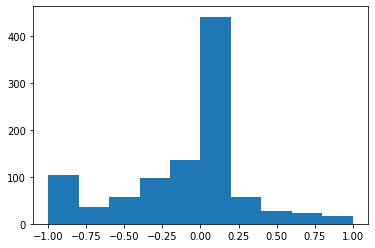

In [341]:
plt.hist(y_ensembled)

<AxesSubplot:ylabel='Density'>

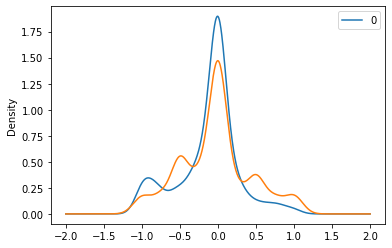

In [342]:
pd.DataFrame(y_ensembled).plot.kde()
eval_df['target'].plot.kde()

In [343]:
np.sqrt(mean_squared_error(eval_df['target'], y_ensembled))

0.5077615557726491

In [344]:
# y_pred = [conv_to_label(x, threshold=0.1)+1 for x in y_ensembled]
y_pred = [1 if -0.25<x<0.15 else np.sign(x)+1 for x in y_ensembled]
print("3-class classification accuracy:", np.mean([int(y_test[i]==y_pred[i]) for i in range(len(y_test))]))

3-class classification accuracy: 0.582


In [345]:
confusion_matrix(y_test, y_pred)

array([[162, 143,  30],
       [ 50, 329,  35],
       [ 61,  99,  91]], dtype=int64)

In [346]:
print(classification_report(y_test, y_pred, target_names=['Left', 'Neutral', 'Right']))

              precision    recall  f1-score   support

        Left       0.59      0.48      0.53       335
     Neutral       0.58      0.79      0.67       414
       Right       0.58      0.36      0.45       251

    accuracy                           0.58      1000
   macro avg       0.58      0.55      0.55      1000
weighted avg       0.58      0.58      0.57      1000



In [ ]:
# normal bert fine-tuning, aug+bert, lstm

## Propagating results of ensemble

In [296]:
with open('backup_before_reindex.json', 'r') as fileobj:
    full_records = json.load(fileobj)

In [297]:
full_records[:3]

[{'submission_id': 'zpre2v',
  'submission_title': '"2 Judges Can\'t Decide": BJP MP\'s Strong Objection On Same-Sex Marriages',
  'subreddit_id': '3d4x4',
  'subreddit_name': 't5_3d4x4',
  'comment_id': 'j0uassz',
  'comment': 'Lets take the argument that its not provided in Indian culture. OK, SO WHAT ? There is no provision saying we have to live according to Indian culture only. We have to live according to our rights and duties in the Constitution and the laws based on it. Dont make Gay Marriage in Hindu Marriage Act, but Special Marriage Act exists so that non-dharmic marriages can exist. Whats the problem there ? Forcing people to live according to your culture is tyranny.',
  'timestamp': '2022-12-19T21:58:40',
  'url': '/r/IndiaSpeaks/comments/zpre2v/2_judges_cant_decide_bjp_mps_strong_objection_on/j0uassz/',
  'reddit_score': 68,
  'redditor_id': 'bu6k2huu',
  'id': '4b5f4c75-9914-4a6d-be95-5b753d4200e6',
  '_version_': 1760900444169699328},
 {'submission_id': 'zpre2v',
  'su

In [318]:
cids = []
comments = []
for record in full_records:
    cids.append(record['comment_id'])
    comments.append(clean_text(record['comment']))
final_preds = pd.DataFrame.from_dict({'comment_id':cids, 'clean_comment':comments})
final_preds['clean_comment'].replace('', np.nan, inplace=True)
final_preds.dropna(inplace=True)
final_preds

,comment_id,clean_comment
0,j0uassz,Lets take the argument that its not provided i...
1,j0vbu5s,Bullshit. If same sex wants to get married the...
2,j0wkxz5,I don't support this MP's views culture has op...
3,j0w3jyf,"Mark my words, BJP is building the nation with..."
4,j0uq3k8,Ok tbh is he...? And on top of all how favouri...
...,...,...
6674,ffqq001,the 20 have drunk the koolaid. In the last ele...
6675,ffq6zn1,"Not really possible. Rest of India, elections ..."
6676,ffq9dxt,I think that cant be further from the truth. S...
6677,ffqcpfc,If they focused on campaigning in urban areas ...


In [319]:
# feature extraction model

# getting train embeddings
temp_df = train_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

# getting prediction embeddings
temp_df = final_preds.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_eval = list(temp_df['final_features'])

print(len(X_train), len(y_train), len(X_eval))

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
xgb.fit(X_train, y_train)
final_preds['y_feat_ext'] = xgb.predict(X_eval)
final_preds.head()

1999 1999 6674


,comment_id,clean_comment,y_feat_ext
0,j0uassz,Lets take the argument that its not provided i...,0
1,j0vbu5s,Bullshit. If same sex wants to get married the...,1
2,j0wkxz5,I don't support this MP's views culture has op...,1
3,j0w3jyf,"Mark my words, BJP is building the nation with...",0
4,j0uq3k8,Ok tbh is he...? And on top of all how favouri...,1


In [321]:
# feature extraction with pca and sentiment

pca = PCA(n_components=8)

# getting train embeddings
temp_df = train_df.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['extracted_features'] = pca.fit_transform(list(temp_df['extracted_features'])).tolist()  # fit transform PCA
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_train, y_train = list(temp_df['final_features']), [np.sign(x)+1 for x in list(temp_df['target'])]

# getting prediction embeddings
temp_df = final_preds.copy()
temp_df['extracted_features'] = temp_df.apply(lambda x: feature_extraction(x['clean_comment']), axis=1)
temp_df['extracted_features'] = pca.transform(list(temp_df['extracted_features'])).tolist()  # transform PCA without re-fitting
temp_df['final_features'] = temp_df.apply(lambda x: add_sentiment_features(x['clean_comment'], x['extracted_features']), axis=1)
X_eval = list(temp_df['final_features'])

print(len(X_train), len(y_train), len(X_eval))

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.005)
xgb.fit(X_train, y_train)
final_preds['y_feat_pca'] = xgb.predict(X_eval)
final_preds.head()

1999 1999 6674


,comment_id,clean_comment,y_feat_ext,y_feat_pca
0,j0uassz,Lets take the argument that its not provided i...,0,2
1,j0vbu5s,Bullshit. If same sex wants to get married the...,1,1
2,j0wkxz5,I don't support this MP's views culture has op...,1,0
3,j0w3jyf,"Mark my words, BJP is building the nation with...",0,0
4,j0uq3k8,Ok tbh is he...? And on top of all how favouri...,1,0


In [348]:
# word level tfidf

vectorizer = TfidfVectorizer(ngram_range=(1, 2), analyzer='word')

X_train = vectorizer.fit_transform(list(train_df['clean_comment']))
X_eval = vectorizer.transform(list(final_preds['clean_comment']))
y_train = [np.sign(x)+1 for x in list(train_df['target'])]

print(X_train.shape, X_eval.shape)

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.001)
xgb.fit(X_train, y_train)
final_preds['y_w_tfidf'] = xgb.predict(X_eval)
final_preds.head()

(1999, 92418) (6674, 92418)


,comment_id,clean_comment,y_feat_ext,y_feat_pca,y_w_tfidf
0,j0uassz,Lets take the argument that its not provided i...,0,2,1
1,j0vbu5s,Bullshit. If same sex wants to get married the...,1,1,1
2,j0wkxz5,I don't support this MP's views culture has op...,1,0,1
3,j0w3jyf,"Mark my words, BJP is building the nation with...",0,0,0
4,j0uq3k8,Ok tbh is he...? And on top of all how favouri...,1,0,1


In [349]:
# subword tfidf

vectorizer = TfidfVectorizer(ngram_range=(2, 10), analyzer='char_wb')

X_train = vectorizer.fit_transform(list(train_df['clean_comment']))
X_eval = vectorizer.transform(list(final_preds['clean_comment']))
y_train = [np.sign(x)+1 for x in list(train_df['target'])]

print(X_train.shape, X_eval.shape)

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05)
xgb.fit(X_train, y_train)
final_preds['y_sw_tfidf'] = xgb.predict(X_eval)
final_preds.head()

(1999, 222782) (6674, 222782)


,comment_id,clean_comment,y_feat_ext,y_feat_pca,y_w_tfidf,y_sw_tfidf
0,j0uassz,Lets take the argument that its not provided i...,0,2,1,0
1,j0vbu5s,Bullshit. If same sex wants to get married the...,1,1,1,1
2,j0wkxz5,I don't support this MP's views culture has op...,1,0,1,0
3,j0w3jyf,"Mark my words, BJP is building the nation with...",0,0,0,0
4,j0uq3k8,Ok tbh is he...? And on top of all how favouri...,1,0,1,1


In [350]:
# augmented data

vectorizer = TfidfVectorizer(ngram_range=(2, 10), analyzer='char_wb')

X_train = vectorizer.fit_transform(list(aug_df['clean_comment']))
X_eval = vectorizer.transform(list(final_preds['clean_comment']))
y_train = [np.sign(x)+1 for x in list(aug_df['target'])]

print(X_train.shape, X_eval.shape)

xgb = xg.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
xgb.fit(X_train, y_train)
final_preds['y_aug'] = xgb.predict(X_eval)
final_preds.head()

(3998, 232104) (6674, 232104)


,comment_id,clean_comment,y_feat_ext,y_feat_pca,y_w_tfidf,y_sw_tfidf,y_aug
0,j0uassz,Lets take the argument that its not provided i...,0,2,1,0,1
1,j0vbu5s,Bullshit. If same sex wants to get married the...,1,1,1,1,1
2,j0wkxz5,I don't support this MP's views culture has op...,1,0,1,0,0
3,j0w3jyf,"Mark my words, BJP is building the nation with...",0,0,0,0,0
4,j0uq3k8,Ok tbh is he...? And on top of all how favouri...,1,0,1,1,1


In [352]:
# frozen bert embeddings

# getting train embeddings from model
with torch.no_grad():
    model.eval()
    X_train = []
    batch_size = 16
    for i in range(0, len(train_df), batch_size):
        temp = tokenizer(list(train_df['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
        X_train.extend(model(temp['input_ids'].to(device), temp['attention_mask'].to(device)).pooler_output.cpu().detach().numpy().tolist())
      
print(len(X_train), len(X_train[0]))

# getting prediction embeddings from model
with torch.no_grad():
    model.eval()
    X_eval = []
    batch_size = 16
    for i in range(0, len(final_preds), batch_size):
        temp = tokenizer(list(final_preds['clean_comment'][i:i+batch_size]), padding='max_length', max_length = 256, truncation=True, return_tensors="pt")
        X_eval.extend(model(temp['input_ids'].to(device), temp['attention_mask'].to(device)).pooler_output.cpu().detach().numpy().tolist())
      
print(len(X_eval), len(X_eval[0]))

y_train = [np.sign(x)+1 for x in list(train_df['target'])]

xgb = xg.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)
final_preds['y_bert_frozen'] = xgb.predict(X_eval)
final_preds.head()

1999 768
6674 768


,comment_id,clean_comment,y_feat_ext,y_feat_pca,y_w_tfidf,y_sw_tfidf,y_aug,y_bert_frozen
0,j0uassz,Lets take the argument that its not provided i...,0,2,1,0,1,0
1,j0vbu5s,Bullshit. If same sex wants to get married the...,1,1,1,1,1,0
2,j0wkxz5,I don't support this MP's views culture has op...,1,0,1,0,0,0
3,j0w3jyf,"Mark my words, BJP is building the nation with...",0,0,0,0,0,0
4,j0uq3k8,Ok tbh is he...? And on top of all how favouri...,1,0,1,1,1,0


In [353]:
final_preds.describe()

,y_feat_ext,y_feat_pca,y_w_tfidf,y_sw_tfidf,y_aug,y_bert_frozen
count,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000
mean,0.867696,0.802817,0.890770,0.878933,0.912346,0.863800
std,0.576030,0.649442,0.489569,0.608174,0.622006,0.698223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [356]:
def final_ensemble(row):
    score = row['y_feat_ext']*10 + row['y_sw_tfidf']*10 + row['y_feat_pca']*8 + row['y_aug']*7 + row['y_w_tfidf']*5 + row['y_bert_frozen']*4
    score /= (10+10+8+7+5+4)
    return score-1

final_preds['predicted_score'] = final_preds.apply(lambda x: final_ensemble(x), axis=1)
final_preds['predicted_label'] = final_preds.apply(lambda x: (0 if -0.25<x['predicted_score']<0.15 else np.sign(x['predicted_score'])), axis=1)
final_preds.head()

,comment_id,clean_comment,y_feat_ext,y_feat_pca,y_w_tfidf,y_sw_tfidf,y_aug,y_bert_frozen,predicted_score,predicted_label
0,j0uassz,Lets take the argument that its not provided i...,0,2,1,0,1,0,-0.363636,-1.0
1,j0vbu5s,Bullshit. If same sex wants to get married the...,1,1,1,1,1,0,-0.090909,0.0
2,j0wkxz5,I don't support this MP's views culture has op...,1,0,1,0,0,0,-0.659091,-1.0
3,j0w3jyf,"Mark my words, BJP is building the nation with...",0,0,0,0,0,0,-1.000000,-1.0
4,j0uq3k8,Ok tbh is he...? And on top of all how favouri...,1,0,1,1,1,0,-0.272727,-1.0


<AxesSubplot:ylabel='Density'>

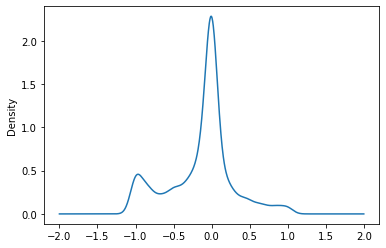

In [357]:
final_preds['predicted_score'].plot.kde()

In [360]:
temp_df = final_preds[['comment_id', 'clean_comment', 'predicted_score', 'predicted_label']].copy()
temp_df.head()

,comment_id,clean_comment,predicted_score,predicted_label
0,j0uassz,Lets take the argument that its not provided i...,-0.363636,-1.0
1,j0vbu5s,Bullshit. If same sex wants to get married the...,-0.090909,0.0
2,j0wkxz5,I don't support this MP's views culture has op...,-0.659091,-1.0
3,j0w3jyf,"Mark my words, BJP is building the nation with...",-1.000000,-1.0
4,j0uq3k8,Ok tbh is he...? And on top of all how favouri...,-0.272727,-1.0


In [363]:
temp_df.to_csv('full_6k_preds.csv', index=False)